<span style="color: red;">NOTE:  
    Sections marked TODO should be completed before final submission.  
    Delete this section when finished.</span>

# AI Academy Semester 1 Capstone

Last Updated: 2022-07-29  
Collaborators: A. Donahue, C. Lineman, N. Netznik, T.V. Nguyen, A. White

# <span style="color: blue;">Background</span>

<span style='color: red'>TODO</span>  
More specifically point out stakeholders (head of CV)

### Business Case

Original video content is a growing field into which many big businesses are investing. The client, Computing Vision, would like to begin creating their own original videos, so they are creating a new movie studio. They are seeking assistance in understanding the current trends in films, specifically which kinds movies are currently doing the best at the box office. They will use these insights to drive their own choices in movie creation.

### Scope

This study will use a variety of historic data on recent movie performance to illuminate trends in profitability and to develop actionable insights for the head of Computing Vision's new movie studio. We will limit data to the range of 2010-present (where available) to ensure that insights are still valid.

### Purpose

The results of this study will provide statistical support for at least three actionable insights that Computing Vision can use to **maximize profits and performance** from their new movie studio.

# <span style="color: blue;">Importing and Processing Data Sources</span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import zipfile
import scipy.stats as st
import math


<span style='color: red'>TODO</span>  
Alex W.: Import and suppress warnings

In [2]:
#read data
movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
movie_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')
reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding='ANSI')
movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

zip_file = "zippedData/im.db.zip"
try:
    with zipfile.ZipFile(zip_file, 'r') as z:
        z.extractall("zippedData/unZipped/")
        print("Extracted all")
except:
    print("Invalid file")

conn = sqlite3.connect("zippedData/unZipped/im.db")

Extracted all


### Data Sources

Our team has thoroughly reviewed 5 different sources of data in which we were able to pull detailed insights that will help lead Computing Vision to success in the movie creation realm. 

#### Sources

* Box Office Mojo(https://www.boxofficemojo.com/)
* IMDB (https://www.imdb.com/)
* Rotten Tomatoes (https://www.rottentomatoes.com/)
* TheMovieDB (https://www.themoviedb.org/)
* The Numbers (https://www.the-numbers.com/)

#### Box Office Mojo

Our team imported Data from Box Office Mojo as we found that it to be a credible resource that provided with a large amount of data and information regarding movie gross values. We successfully pulled and sized the data to present us with a data frame of 3387 movies including the movie title, the studio of production, the domestic and foreign gross values of each movie, and the year the movie was released as well. 



#### IMDB

Internet Movie Database (IMDb) is considered the largest and most comprehensive movie databases. This database provides information related to films, television series, home videos, video games, and streaming content. Our team found this source to be a valuable as it allowed us to view a large depository of movies specific information. This source allowed us to pull a wide arrange of data and source into different tables that includes information on movie personal, principals, directors, writer, rating, basics, etc.

#### Rotten Tomatoes 

Rotten Tomatoes is a review aggregation website for film and television. Rotten Tomatoes is one of the most trusted recommendations recourses for quality of entertainment. Rotten tomatoes specify in reviews from critics and provides a comprehensive guide on ratings for movies. We were able to use this source to specify the relation of Rotten Tomatoes rating and movies success. As well link these rating to several different aspects in which we give insights on throughout the analysis. This source was able to provide was with multiple different data frames in which our team use primarily in two which include data on Movie reviews and Movie specific information.  Regarding movie information we were successfully able to pull data on 1560 movies with details regarding synopsis, MPA Rating (PG, PG13, R, etc.), genre, director, writer, Theater date, DVD release date, currency, Box office sales, movie runtime, and production studio.  

As well with the use of Rotten tomatoes source we were able to import a data frame allowing us to view details on movie reviews. We were able to import 54432 data points that gave us compressive information regarding movie ID, distinct reviews, review rating, fresh/rotten specification, critic of the review, the top critic, publisher, and date of review. We must note that this data frame provided was with multiple reviews from different critics through different publishers on different dates for the movies. 


#### The MovieDB 

The Movie Database (TMDB) is a community-built movie and TV database. This data base was able to provide us insights on individual movie specifics and there rating.  We were able to successfully import 26517 movies with information regarding genre, language, title, popularity, release date, vote average and vote count regarding movie rating. 

#### The Numbers

The Numbers is a film industry data website that tracks box office revenue.  We primarily used this source to generate a data frame that provided information regarding movie budgets. Digging deeper we were able to pull information for 5782 movies with details on Release date, Movie title, production budget, domestic gross, and worldwide gross. Our team found this provided data to valuable in regards of generating profit percentage and movie success throughout our overall analysis. 

#### Limitations  

We must also note that our team did run into some limitations when it came to connecting and merging data frames due to differentiation in primary keys. Our team found that the best fit primary key to over come this issue was merging and connecting through movie titles. 

The specific limitation with the use of titles is that they could potentially be less consistent than numeric identifiers.

# <span style="color: blue;">Data Preparation & Cleaning</span>

In [3]:
# Turn foreign gross to an int
movie_gross['foreign_gross'] = movie_gross['foreign_gross'].str.replace(',','')
movie_gross['foreign_gross'] = movie_gross["foreign_gross"].astype("float64")

# Turned run time into an integer
movie_info['runtime'] = movie_info['runtime'].str.replace(' minutes','')
movie_info['runtime']  = movie_info['runtime'].astype("float64")

# Turned box_offices into an interger
movie_info['box_office'] = movie_info['box_office'].str.replace(',','')
movie_info['box_office'] = movie_info['box_office'].astype("float64")

# Change currency to binary variable
for i in movie_info['currency']:
    if i is not None:
        i = 1
    else:
        i = 0

# Update 'fresh'/'rotten' in reviews to boolean variable
reviews['fresh'] = reviews['fresh'].str.replace('fresh','1')
reviews['fresh'] = reviews['fresh'].str.replace('rotten','0')
reviews['fresh']  = reviews['fresh'].astype("float64")

reviews.drop_duplicates(inplace=True)

A brief analysis reveals that ratings within the Rotten Tomatoes reviews database are very inconsistent. We seek to clean and reorganize these ratings to make them usable.

We will make the following modifications to the ratings column:

* We will be changing all letter "grades" to numerical scores out of 10, evenly distributed between 0 and 10.
    * Note that F+ and F- will be grouped with F.
* We will be replacing all NaN ratings, ratings out of 2, all ratings without an "out-of" denominator, and any other nonsensical ratings with '-1/1'. This will allow us to split all ratings by the '/' character before making further calculations in the future; upon performing these calculations we will go back and reset all '-1/1' values to NaN.

In [4]:
# Change letter ratings to numerical (out of 10)
reviews['rating'].replace('F+', 'F', inplace=True)
reviews['rating'].replace('F-', 'F', inplace=True)

letter_ratings = ['A+','A','A-','B+','B','B-','C+','C','C-','D+','D','D-','F']
nums = list(np.round(np.linspace(0,10, 13), 1))
num_ratings = [f'{str(num)}/10' for num in nums]
mapping = dict(zip(letter_ratings, num_ratings))

for rating in letter_ratings:
    reviews.replace(rating, mapping[rating], inplace=True)

reviews['rating'].fillna('-1/1', inplace=True)
    
# Remove all ratings that do not contain '/'
for rating in reviews['rating'].unique():
    if "/" not in rating:
        reviews['rating'].replace(rating, '-1/1', inplace=True)

# Remove other nonsensical ratings
reviews['rating'].replace('R', '-1/1', inplace=True)
reviews['rating'].replace('N', '-1/1', inplace=True)
reviews['rating'].replace('T', '-1/1', inplace=True)

reviews['rating'].replace('1/2', '-1/1', inplace=True)
reviews['rating'].replace('2/2', '-1/1', inplace=True)
reviews['rating'].replace('3/2', '-1/1', inplace=True)
reviews['rating'].replace('3 1/2', '-1/1', inplace=True)
reviews['rating'].replace('1-5', '-1/1', inplace=True)
reviews['rating'].replace('5/4', '-1/1', inplace=True)
reviews['rating'].replace('2.1/2', '-1/1', inplace=True)
reviews['rating'].replace('5.5/5', '-1/1', inplace=True)

In [5]:
# Remove unwanted symbols from string values and cast string values as floats

movie_budgets['production_budget'] = movie_budgets['production_budget'].str.replace(',','')
movie_budgets['production_budget'] = movie_budgets['production_budget'].str.replace('$', '')
movie_budgets['production_budget'] = movie_budgets['production_budget'].astype("float64")

movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].str.replace(',','')
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].str.replace('$', '')
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].astype("float64")

movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].str.replace(',','')
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].str.replace('$', '')
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].astype("float64")

# Change type of release_date to datetime
movie_budgets['release_date'] = pd.to_datetime(movie_budgets['release_date'])

# Clean titles to make them consistent/comparable

movie_gross['title'] = movie_gross['title'].str.strip().str.replace('[^\w\s]', '')
movies['original_title'] = movies['original_title'].str.strip().str.replace('[^\w\s]', '')
movie_budgets['movie'] = movie_budgets['movie'].str.replace("â€™", "'") # replaces improperly encoded ' characters
movie_budgets['movie'] = movie_budgets['movie'].str.strip().str.replace('[^\w\s]', '')

movie_gross['title'] = movie_gross['title'].str.upper()
movies['original_title'] = movies['original_title'].str.upper()
movie_budgets['movie'] = movie_budgets['movie'].str.upper()


# <span style="color: blue;">Analysis of Selected Variables</span>

## Budget vs. Profit Ratio

<span style="color: red;">TODO</span>  
Add justification and explanation

In [6]:
movie_budgets["profit"] = movie_budgets['worldwide_gross'] - movie_budgets['production_budget']

movie_budgets.rename(columns = {'movie' : 'title'}, inplace = True)
grossJoinBudget = pd.DataFrame.merge(movie_gross, movie_budgets, on = 'title')

movie_budgets["profit"] = movie_budgets['worldwide_gross'] - movie_budgets['production_budget']

grossJoinBudget.fillna(0, inplace=True)

<span style='color: red'>TODO</span>  
Explain justification for 2 million cutoff point

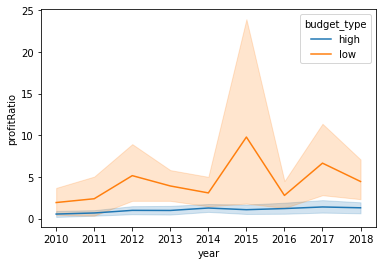

In [7]:
grossJoinBudget['budget_type'] = grossJoinBudget['production_budget'].map(lambda x: 'high' if x >= 20000000  else 'low' )

grossJoinBudget['profitRatio'] = (grossJoinBudget['profit'] - grossJoinBudget['production_budget']) / grossJoinBudget['production_budget']

sns.lineplot(x='year', y='profitRatio', hue='budget_type', data=grossJoinBudget);

#### Hypothesis test for budget vs profit ratios  
<span style='color: red'>TODO</span>  Revise hypothesis testing code/markdown to one-tailed test

We will conduct a one-tailed two sample t-test with a 5% level of significance to conclude whether low budget movies yield higher product ratios on average than high budget movies.

    Null: There is no difference in profit ratios between high and low budget movies.
    Alternative: Low budget movies yield higher product ratios on average than high budget movies.

<span style='color: red'>TODO</span>  
Colton: Change code to use earlier column

In [8]:
# s1 = grossJoinBudget.loc[high]['profitRatio']
# s2 = grossJoinBudget.loc[low]['profitRatio']

In [9]:
# type(s1)

In [10]:
# s2

In [11]:
# plt.boxplot([s1, s2]);

<span style='color: red'>TODO</span>  
Colton: Consider changing to IQR formula; move removing of outliers to earlier in section

In [12]:
# s1 = s1[(s1>np.quantile(s1,0.25)) & (s1<np.quantile(s1,0.75))].tolist()

In [13]:
# s2 = s2[(s2>np.quantile(s2,0.25)) & (s2<np.quantile(s2,0.75))].tolist()

In [14]:
# plt.boxplot([s1, s2]);

In [15]:
# # stat, pval = st.ttest_ind(s1,s2,equal_var = False)
# pval/2

**Conclusion:** We would reject the NULL  
<span style="color: red;">TODO</span>  
What does it mean? Include business recommendation.

## Genre vs. Profit Ratio

We want to take a look at how the major genres perform around the world relative to their global average performance to determine which genres are the most profitable.

In [16]:
q1= """
SELECT * 
FROM movie_basics
INNER JOIN movie_ratings
USING("movie_id")
INNER JOIN movie_akas
USING("movie_id")



"""
sql_dataset_merge1 = pd.read_sql(q1,conn)
sql_dataset_merge1['title'] = sql_dataset_merge1['title'].str.upper()

<span style='color: red'>TODO</span>  
Van: Do we need to show the tables every time?

In [17]:
#keep only original movie
sql_dataset_merge1= sql_dataset_merge1[sql_dataset_merge1.is_original_title==1]

data= movie_budgets.merge(sql_dataset_merge1, how= 'inner', left_on='title', right_on= 'title')

dataset= data[[ 'release_date', 'title', 'production_budget',
       'domestic_gross', 'worldwide_gross',
       'start_year',
       'runtime_minutes', 'genres', 'averagerating', 'numvotes', 'ordering']]



<span style='color: red'>TODO</span>  
Van: Justify dropping data

In [18]:
dataset=dataset.dropna()

In [19]:
## calulate profit by subtracting gross and budget and foreign gross by subtracting gross and budget domestic_gross
dataset['profit']= dataset['worldwide_gross']- dataset['production_budget']
dataset['foreign_gross']= dataset['worldwide_gross']- dataset['domestic_gross']
# dataset.loc[dataset['profit'] < 0, 'profit']= 0
##calulate profit ratio
dataset['profit_ratio'] = (dataset['profit'] - dataset['production_budget']) / dataset['production_budget']

I want to split up the genres column cells so we can tally each genre individually. Next I'll remove the 'genres' column (with multiple values) and replace it with a 'genre' column (with single values). Then I'll make sure that there is a new row for each genre, so there will be multiple rows with the same movie_title.


In [20]:
df_split_genre = dataset.copy()
split_genre = df_split_genre['genres'].str.split(',').apply(pd.Series, 1).stack().reset_index(level=1, drop=True)
split_genre.name = 'genre_split'
df_split_genre = df_split_genre.drop(['genres'], axis=1).join(split_genre)

# limit data to 2010-present
df_split_genre = df_split_genre.loc[df_split_genre['release_date'].dt.year >= 2010]

<span style='color: red'>TODO</span>  
Remove extraneous text below?

### Visualize dataset

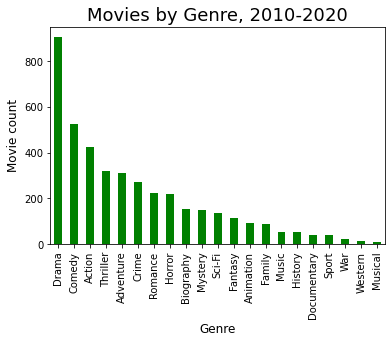

In [21]:
df_split_genre['genre_split'].value_counts().plot(kind='bar', color='g');
plt.title('Movies by Genre, 2010-2020', size=18)
plt.xlabel('Genre', size=12)
plt.ylabel('Movie count', size=12);

In terms of the number of releases worldwide, dramas and comedies top the list ( in North America) between 2010 and 2020 as more than 500 comedy films were released and over 900 drama films have been released.

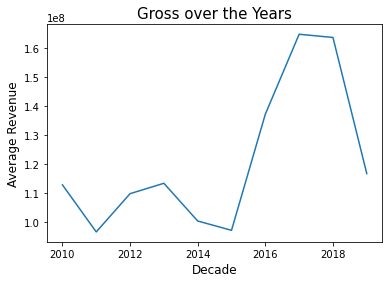

In [22]:
#line gross
gross_mean= df_split_genre.groupby(df_split_genre['start_year'])['worldwide_gross'].mean()
plt.plot(gross_mean)
plt.title('Gross over the Years', size=15);
plt.xlabel('Decade', size=12)
plt.ylabel('Average Revenue', size=12);

<span style="color: red">TODO</span>  
Move this up somewhere

In [23]:
genre_profit=df_split_genre[['genre_split','profit_ratio']].sort_values('genre_split').reset_index(level=0, drop=True)

### Hypothesis testing

<span style="color: red;">TODO</span>  
Declare H0/HA; set alpha=0.05

In [24]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('profit_ratio ~ C(genre_split)', data=genre_profit).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table


,sum_sq,df,F,PR(>F)
C(genre_split),13114.623621,20.0,4.176862,1.264954e-09
Residual,648845.153437,4133.0,NaN,NaN


The p value obtained from ANOVA analysis is significant (p < 0.05), and therefore, we conclude that there are significant differences among genre.

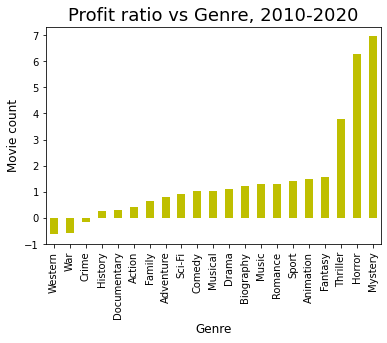

In [25]:
profit_ratio_genre=df_split_genre.groupby('genre_split')['profit_ratio'].mean().sort_values()
profit_ratio_genre.plot(kind='bar', color='y');
plt.title('Profit ratio vs Genre, 2010-2020', size=18)
plt.xlabel('Genre', size=12)
plt.ylabel('Movie count', size=12);

<span style="color: red">TODO</span>  
Move this up for posterity

In [26]:
  
# display model summary
# print(model.summary())


From ANOVA analysis, we know that genre differences are statistically significant, but ANOVA does not tell which genre are significantly different from each other. To know the pairs of significant different treatments, we will perform multiple pairwise comparison (post hoc comparison) analysis for all unplanned comparison using Tukey’s honestly significantly differenced (HSD) test.

Note: When the ANOVA is significant, post hoc tests are used to see differences between specific groups. post hoc tests control the family-wise error rate (inflated type I error rate) due to multiple comparisons. post hoc tests adjust the p values (Bonferroni correction) or critical value (Tukey's HSD test).

We have Tukey’s HSD test for multiple comparisons and corrects for family-wise error rate (FWER) (inflated type I error)
 
 
 Link reference:https://www.reneshbedre.com/blog/anova.html

In [27]:
 !pip install bioinfokit;

In [28]:
# we will use bioinfokit (v1.0.3 or later) for performing tukey HSD test
# check documentation here https://github.com/reneshbedre/bioinfokit
##install bioinfokit package
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=genre_profit, res_var='profit_ratio', xfac_var='genre_split', anova_model='profit_ratio ~ C(genre_split)')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Action,Adventure,0.379659,-2.958043,3.717362,0.574543,0.9
1,Action,Animation,1.042500,-4.057050,6.142049,1.032571,0.9
2,Action,Biography,0.778788,-3.459530,5.017105,0.928115,0.9
3,Action,Comedy,0.584592,-2.334785,3.503969,1.011437,0.9
4,Action,Crime,0.592273,-2.884896,4.069442,0.860344,0.9
...,...,...,...,...,...,...,...
205,Sport,War,1.992699,-9.772479,13.757876,0.855498,0.9
206,Sport,Western,2.027741,-11.914754,15.970235,0.734595,0.9
207,Thriller,War,4.370089,-5.290576,14.030753,2.284858,0.9
208,Thriller,Western,4.405130,-7.813797,16.624058,1.820965,0.9


<span style="color: red">TODO</span>  
Show only the important results from this call

In [29]:
##filter p-value less than 0.05
res.tukey_summary[res.tukey_summary['p-value']< 0.05].sort_values('p-value')

,group1,group2,Diff,Lower,Upper,q-value,p-value
10,Action,Horror,5.841909,2.126565,9.557253,7.942036,0.001000
125,Drama,Mystery,5.846141,1.878267,9.814016,7.441962,0.001000
122,Drama,Horror,5.174124,1.810251,8.537996,7.769147,0.001000
98,Crime,Mystery,7.106200,2.532261,11.680139,7.847351,0.001000
83,Comedy,Mystery,5.929335,1.763644,10.095025,7.189439,0.001000
80,Comedy,Horror,5.257317,1.662239,8.852395,7.386383,0.001000
95,Crime,Horror,6.434182,2.373083,10.495282,8.002502,0.001000
32,Adventure,Mystery,6.134267,1.665434,10.603101,6.933373,0.001000
29,Adventure,Horror,5.462250,1.519905,9.404594,6.998307,0.001000
13,Action,Mystery,6.513927,2.244012,10.783841,7.705481,0.001000


Above results from Tukey’s HSD suggests that all other pairwise comparisons for treatments rejects null hypothesis (p < 0.05) and indicates statistical significant differences.

# Ratings by Director versus Profit and Profit Ratio

In addition to exploring profits of different movie genres, we will explore which kinds of directors could help Computing Vision generate profits most effectively. In particular, we will be investingating the relationship between average movie rating by director with profit and profit ratio.

### Creating Standardized Ratings Column 

In [30]:
# Create columns representing all movie ratings out of 10 stars
reviews['num_stars'] = reviews['rating'].map(lambda x : float(x.split('/')[0]))
reviews['out_of_stars'] = reviews['rating'].map(lambda x : float(x.split('/')[1]))
reviews['rating_out_of_10'] = reviews['num_stars'] / reviews['out_of_stars'] * 10

# Replace bogus values with NaN
reviews['rating'].replace('-1/1', np.nan, inplace=True)
reviews['num_stars'].replace(-1.0, np.nan, inplace=True)
reviews['out_of_stars'].replace(1.0, np.nan, inplace=True)
reviews['rating_out_of_10'].replace(-10.0, np.nan, inplace=True)

# Exploratory Data Analysis on Rotten Tomatoes Ratings

The following histogram presents the distribution of movie ratings (out of 10). The ratings, each between 0 and 10, are classified into 10 bins whose frequencies are plotted.

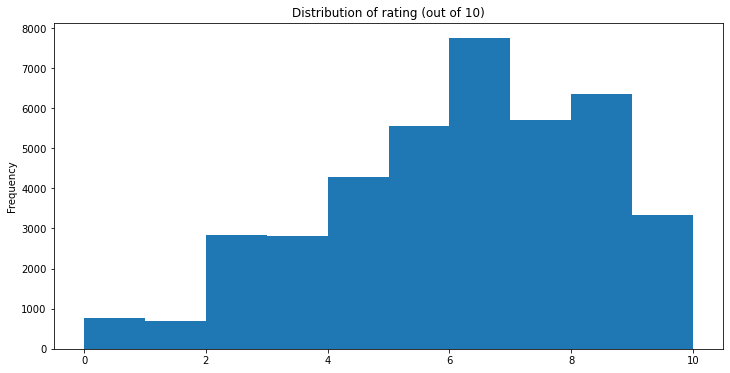

In [31]:
reviews['rating_out_of_10'].plot(figsize=(12,6), kind='hist', title='Distribution of rating (out of 10)', bins=10);

In [32]:
reviews['rating_out_of_10'].mean()

5.91708490119365

In [33]:
reviews['rating_out_of_10'].median()

6.0

In [34]:
reviews['rating_out_of_10'].mode()

0    6.0
dtype: float64

We have found that movies average approximately **6 out of 10 stars**. We could consider movies with below 6 out of 10 stars to be below average and movies with above 6 out of 10 stars to be above average.

# Research Question
Do a **director's previous movie ratings** relate to the **profit** and/or **profit ratio** that their movies generate?

## Approach
To answer this question, we will begin by creating two groups of directors - those with a "good" average movie rating, and those with a "bad" average movie rating. We will determine a threshold by which we can classify ratings as "good" or "bad" upon investigating Rotten Tomatoes rating data. To determine the threshold, we will group the reviews into those with a "fresh" flag and those with a "rotten" flag, then will investigate the distribution of ratings in each. We will also consider the results from the exploratory data analysis performed above.

Upon choosing a threshold, we will use IMDB databases joined with movie budget data from The Numbers to calculate mean movie rating by director along with the director's mean profit and mean profit ratio. In particular, we are interested in established directors - those who have received over 1,000 reviews and have worked on at least two movies. We will then split these directors into two groups - one group with mean ratings of greater than or equal to the threshold, and one with mean ratings below the threshold.

We will then conduct hypothesis tests to determine whether there is a relationship between:
* Mean rating by director and mean profit
* Mean rating by director and mean profit ratio

### Determining a Threshold

In [35]:
rotten_tomatoes = movie_info.merge(reviews, on='id')

In [36]:
# Obtain lists of "rotten" and "fresh" reviews
fresh_reviews = rotten_tomatoes.loc[rotten_tomatoes['fresh'] == 1]
rotten_reviews = rotten_tomatoes.loc[rotten_tomatoes['fresh'] == 0]

Here we will investigate the distributions of "rotten" movie review ratings and "fresh" movie review ratings. We will generate overlayed histograms to visualize how the distributions of rotten movie ratings and fresh movie ratings compare to each other.

C:\Users\nnetznik\Anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\nnetznik\Anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


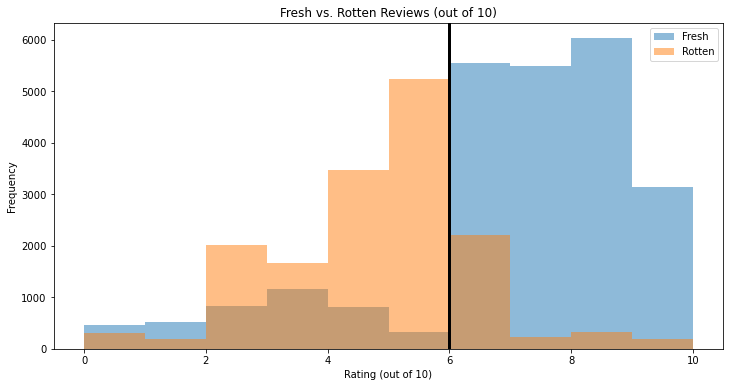

In [37]:
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(fresh_reviews['rating_out_of_10'], alpha=0.5)
ax.hist(rotten_reviews['rating_out_of_10'], alpha=0.5)
ax.set_title("Fresh vs. Rotten Reviews (out of 10)")
ax.set_xlabel("Rating (out of 10)")
ax.set_ylabel("Frequency")
ax.legend(['Fresh','Rotten'])
plt.axvline(x=6, color='black', lw=3);

We note that there are some low ratings corresponding to "fresh" reviews, as well as some high ratings corresponding to "rotten" reviews. We are unsure of why this occurs.

Based upon the visualization above, 6 stars out of 10 appears to be the point where reviews transition from mostly rotten to mostly fresh. We also observed previously that the overall distribution of ratings has a center near 6 out of 10. We will use **6 stars out of 10** as a threshold to differentiate between positive reviews and negative reviews.

### Gathering Data

In [38]:
directorRatings = pd.read_sql("""
    SELECT 
    persons.primary_name AS director, movie_basics.original_title AS title, movie_ratings.averagerating AS AVG_Movie_rating
    FROM persons
    JOIN principals
        USING(person_id)
    JOIN movie_basics
        USING(movie_id)
    JOIN movie_ratings
        USING(movie_id)
    GROUP BY persons.primary_name
    HAVING principals.category == 'director' AND movie_ratings.numvotes >= 1000 AND COUNT(movie_ratings.movie_id) > 1
    ORDER BY AVG_Movie_rating DESC
  ;
""", conn)

directorRatings['title'] = directorRatings['title'].str.upper()

movie_budgets['profit'] = movie_budgets['worldwide_gross']-movie_budgets['production_budget']

budgetJoinDirector = movie_budgets.merge(directorRatings, left_on = 'title', right_on='title')

# Only keep rows with year >= 2010
budgetJoinDirector['year'] = budgetJoinDirector['release_date'].dt.year
budgetJoinDirector = budgetJoinDirector.loc[budgetJoinDirector['year'] >= 2010]

# Drop unnecessary columns
budgetJoinDirector=budgetJoinDirector.drop('id', axis =1)
budgetJoinDirector=budgetJoinDirector.drop('release_date', axis =1)
budgetJoinDirector=budgetJoinDirector.drop('title', axis =1)

# Create profit and profit ratio columns
budgetJoinDirector['profit'] = budgetJoinDirector['worldwide_gross']-budgetJoinDirector['production_budget']
budgetJoinDirector['profitRatio'] = (budgetJoinDirector['worldwide_gross'] - budgetJoinDirector['production_budget'])/ budgetJoinDirector['production_budget']

# Create positive review column
budgetJoinDirector['positive_review'] = budgetJoinDirector['AVG_Movie_rating'] >= 6

# Group directors by mean movie rating
grouped = budgetJoinDirector.groupby('director').mean().sort_values('AVG_Movie_rating', ascending = False)

### Investigating Data

In [39]:
avg_movie_rating = grouped['AVG_Movie_rating']
avg_profit = grouped['profit']
profitRatioGroup = grouped['profitRatio']

We will first investigate the distributions of profit and profit ratio. Below are histograms corresponding to each. Note that the axes have differing units and scales. Also note the use of scientific notation along the x and y axes in the first plot.

C:\Users\nnetznik\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\nnetznik\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


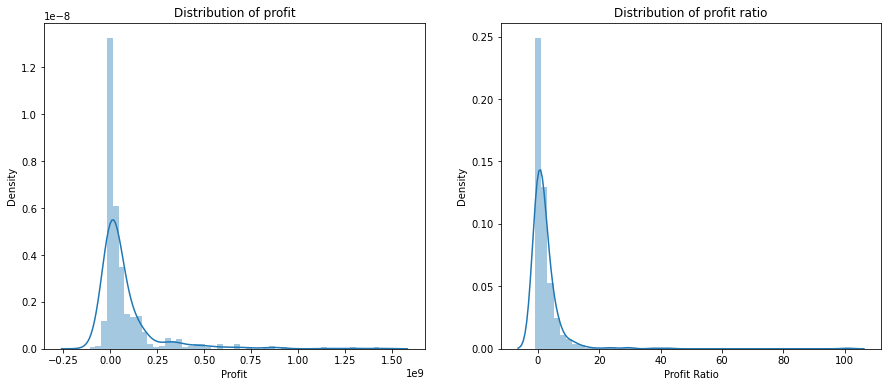

In [40]:
fig, ax = plt.subplots(ncols=2, figsize=(15,6))
sns.distplot(avg_profit, ax=ax[0])
sns.distplot(profitRatioGroup, ax=ax[1])
ax[0].set_title('Distribution of profit')
ax[0].set_xlabel('Profit')
ax[0].set_ylabel('Density')
ax[1].set_title('Distribution of profit ratio')
ax[1].set_xlabel('Profit Ratio')
ax[1].set_ylabel('Density');

It appears that our profit and profit ratio data contains several outliers. We will trim these outliers using the **IQR rule** before proceeding with our analysis so we can focus on typical profits.

### Investigating Trimmed Data

In [41]:
# IQR Rule: keep values in interval [Q1 - 1.5*IQR, Q3 + 1.5*IQR]

Q1 = grouped['profit'].quantile(0.25)
Q3 = grouped['profit'].quantile(0.75)
IQR = Q3-Q1
grouped_trimmed = grouped.loc[(grouped['profit'] >= Q1-1.5*IQR) & (grouped['profit'] <= Q3 + 1.5*IQR)]
avg_movie_rating = grouped_trimmed['AVG_Movie_rating']
avg_profit = grouped_trimmed['profit']

Q1 = grouped['profitRatio'].quantile(0.25)
Q3 = grouped['profitRatio'].quantile(0.75)
IQR = Q3-Q1
grouped_clean = grouped.loc[(grouped['profitRatio'] >= Q1-(1.5*IQR)) & (grouped['profitRatio'] <= Q3 + 1.5*IQR)]
profitRatio = grouped_clean['profitRatio']
avg_movie_rating_ratio = grouped_clean['AVG_Movie_rating']

Again we plot the distributions of profit and profit ratio. Observe that extreme values have been trimmed.

C:\Users\nnetznik\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\nnetznik\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


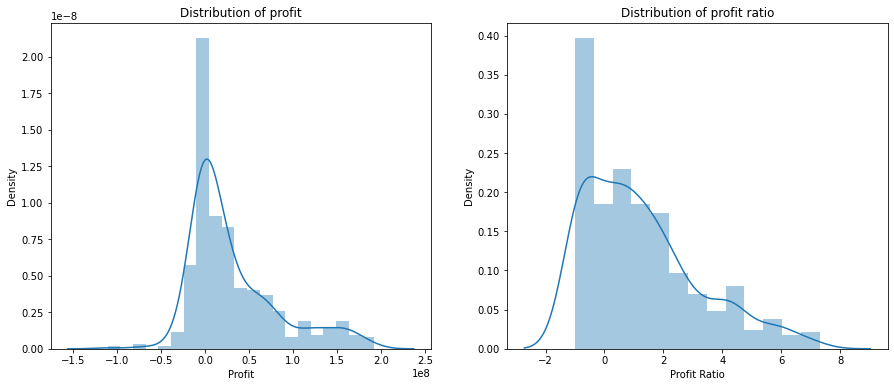

In [42]:
fig, ax = plt.subplots(ncols=2, figsize=(15,6))
sns.distplot(avg_profit, ax=ax[0])
sns.distplot(profitRatio, ax=ax[1])
ax[0].set_title('Distribution of profit')
ax[0].set_xlabel('Profit')
ax[0].set_ylabel('Density')
ax[1].set_title('Distribution of profit ratio')
ax[1].set_xlabel('Profit Ratio')
ax[1].set_ylabel('Density');

In [43]:
# Split profits into two groups based on mean director rating
greaterThanEqual6_trimmed = grouped_trimmed.loc[avg_movie_rating >= 6]['profit']
lessThan6_trimmed = grouped_trimmed.loc[avg_movie_rating < 6]['profit']

# Split profit ratios into two groups based on mean director rating
greaterThanEqual6_trimmed_ratio = grouped_clean.loc[grouped_clean['AVG_Movie_rating'] >= 6]['profitRatio']
lessThan6_trimmed_ratio = grouped_clean.loc[grouped_clean['AVG_Movie_rating'] < 6]['profitRatio']

Below we will generate scatter plots with regression lines for mean movie rating by director vs. mean profit and mean movie rating by director vs. mean profit ratio. We will also plot a vertical red line in each graph at x=6 where we differentiate good ratings from bad ratings. These plots will allow us to visualize the relationships between director and profit as well as profit ratio. Again note the different units and scales of the y-axes as well as the use of scientific notation in the y-axis in the first graph.

C:\Users\nnetznik\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nnetznik\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


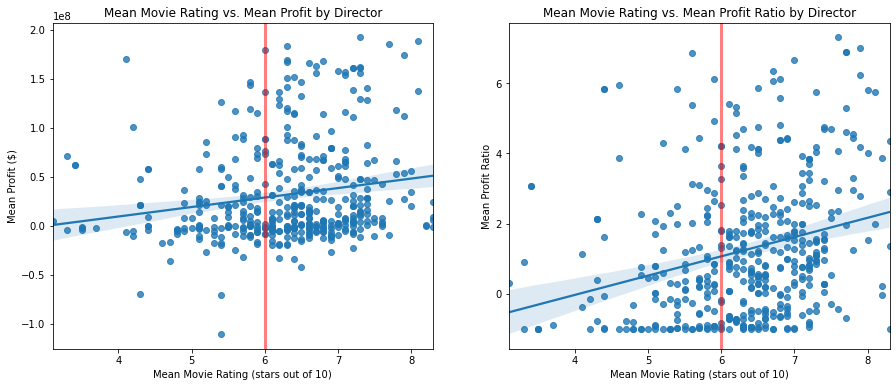

In [44]:
fig, ax = plt.subplots(ncols=2, figsize=(15,6))
sns.regplot(avg_movie_rating, avg_profit, ax=ax[0])
ax[0].axvline(6, color='red', lw=3, alpha=0.5);
ax[0].set_title('Mean Movie Rating vs. Mean Profit by Director')
ax[0].set_xlabel('Mean Movie Rating (stars out of 10)')
ax[0].set_ylabel('Mean Profit ($)')

sns.regplot(avg_movie_rating_ratio, profitRatio, ax=ax[1])
ax[1].axvline(6, color='red', lw=3, alpha=0.5);
ax[1].set_title('Mean Movie Rating vs. Mean Profit Ratio by Director')
ax[1].set_xlabel('Mean Movie Rating (stars out of 10)')
ax[1].set_ylabel('Mean Profit Ratio')
plt.ticklabel_format(style='plain');

Below we will compute and present summary statistics for both profit and profit ratio, split by mean rating group.

In [45]:
print(
    'SUMMARY STATISTICS: PROFIT\n\n'
    + 'Group\t\t\tMean\t\t\tVariance\n'
    + '---------------------------------------------------------------------\n'
    + f'Mean rating >= 6\t{greaterThanEqual6_trimmed.mean()}\t{greaterThanEqual6_trimmed.std(ddof=1)**2}\n'
    + f'Mean rating < 6\t\t{lessThan6_trimmed.mean()}\t{lessThan6_trimmed.std(ddof=1)**2}\n\n'
    + f'Difference between means {greaterThanEqual6_trimmed.mean() - lessThan6_trimmed.mean()}\n\n\n'
)

print(
    'SUMMARY STATISTICS: PROFIT RATIO\n\n'
    + 'Group\t\t\tMean\t\t\tVariance\n'
    + '---------------------------------------------------------------------\n'
    + f'Mean rating >= 6\t{greaterThanEqual6_trimmed_ratio.mean()}\t{greaterThanEqual6_trimmed_ratio.std(ddof=1)**2}\n'
    + f'Mean rating < 6\t\t{lessThan6_trimmed_ratio.mean()}\t{lessThan6_trimmed_ratio.std(ddof=1)**2}\n\n'
    + f'Difference between means {greaterThanEqual6_trimmed_ratio.mean() - lessThan6_trimmed_ratio.mean()}\n'
)

SUMMARY STATISTICS: PROFIT

Group			Mean			Variance
---------------------------------------------------------------------
Mean rating >= 6	37372798.47979798	2851196205844287.0
Mean rating < 6		18683923.664233577	1744435558069636.8

Difference between means 18688874.815564405



SUMMARY STATISTICS: PROFIT RATIO

Group			Mean			Variance
---------------------------------------------------------------------
Mean rating >= 6	1.4726288164792676	3.7241493891037725
Mean rating < 6		0.7066289995706767	3.5128951298457545

Difference between means 0.7659998169085909



#### Observations
* There is a **slight positive relationship** between mean movie rating by director and mean profit.
* There is a **slight positive relationship** between mean movie rating by director and mean profit ratio.
* Mean profit **differs** by rating group; so does mean profit ratio.
* Variance of profit **differs** by rating group, so does variance of profit ratio.

## Analysis

We will use hypothesis testing to evaluate our suspicion that directors with high historical ratings (averaging at least 6 out of 10) generate higher profits and profit ratios than directors with low historical ratings (averaging less than 6 out of 10). Using $\alpha=0.05$, we will conduct one-tailed unpaired Welch's t-tests (which do *not* assume that population variances are equal).

### Test 1
Let:

> $\mu_{Profit, GE6}$ denote the mean profit for directors with a mean rating of greater than or equal to 6;

> $\mu_{Profit, L6}$ denote the mean profit for directors with a mean rating of less than 6.


$H_{0}: \mu_{Profit, GE6} - \mu_{Profit, L6} = 0$

$H_{A}: \mu_{Profit, GE6} - \mu_{Profit, L6} > 0$

### Test 2
Let:

> $\mu_{Ratio, GE6}$ denote the mean profit *ratio* for directors with a mean rating of greater than or equal to 6;

> $\mu_{Ratio, L6}$ denote the mean profit *ratio* for directors with a mean rating of less than 6.


$H_{0}: \mu_{Ratio, GE6} - \mu_{Ratio, L6} = 0$

$H_{A}: \mu_{Ratio, GE6} - \mu_{Ratio, L6} > 0$

In [46]:
# Test 1
statistic, pvalue = st.ttest_ind(greaterThanEqual6_trimmed, lessThan6_trimmed, equal_var=False)
pvalue/2

4.686646375630644e-05

In [47]:
# Test 2
statistic, pvalue = st.ttest_ind(greaterThanEqual6_trimmed_ratio, lessThan6_trimmed_ratio, equal_var=False)
pvalue/2

5.2855105942360924e-05

### Results
Each of these p-values falls below our level of significance of $0.05$. We reject the null hypothesis in both cases.

### Conclusion
Our hypothesis tests yield strong evidence that directors with a mean rating greater than or equal to 6 out of 10 produce **greater mean profits and greater mean profit ratios** than directors with a lower mean rating.

## Recommendation
We recommend that Computing Vision hire directors with **strong historical movie ratings**.

## Season vs. Gross Profit 

<span style='color: red'>TODO</span>  
Alex D. (or Colton): Create explanatory markdown and comment code  
Drop outliers  
Add intro  
Add conclusion  
Add business suggestion

# Research Question

##### Is there a direct correlation in which season a movie is released and the gross profits generated?

# Approach

We will begin by making needed adjustments to to the movie budgets and movie gross data frames. Following the required adjustments we will merge the two data frames into one. We will then filter and clean the merged data frame to till we recieve the desired output to run our statistical analysis and create the appropriate visualizions that compare season relase date to gross profits

separate release date

Create new collumn as release month

In [80]:
release_month = movie_budgets['release_date'].dt.strftime('%m')
movie_budgets['release_month']= release_month

Create new collumn for relase year

In [81]:
release_year = movie_budgets['release_date'].dt.strftime('%Y')
movie_budgets['release_year']= release_year

Creat dictionary to correalte each release month to a specifice Season

<span style="color: red">TODO</span>  
Move up to cleaning section

In [82]:
#Season: spring = 1, summer=2, fall= 3, winter=4
season_dict = {'01': '4',
               '02': '4',
               '03': '1', 
               '04': '1',
               '05': '1',
               '06': '2',
               '07': '2',
               '08': '2',
               '09': '3',
               '10': '3',
               '11': '3',
               '12': '4'}
movie_budgets['Season'] = movie_budgets['release_month'].apply(lambda x: season_dict[x])

convert relase month, release year, and season to integers

In [83]:
movie_budgets['release_year']  = movie_budgets['release_year'].astype("int")
movie_budgets['release_month']  = movie_budgets['release_month'].astype("int")
movie_budgets['Season']  = movie_budgets['Season'].astype("int")

#### Merge Gross and budgets

In [84]:
movieGrossJoinBudgets = pd.DataFrame.merge(movie_gross, movie_budgets, on = 'title')

Check for null values

Set Null Values to 0

In [85]:
movieGrossJoinBudgets.fillna(0, inplace = True)

calculate for inflations in the merged data frame

In [86]:
i = 0
for row in movieGrossJoinBudgets.itertuples(index = False):
    if row[4] == 2010:
        movieGrossJoinBudgets.iat[i,2] = row[2] * ((8*.0151) + 1)

    if row[4] == 2011:
        movieGrossJoinBudgets.iat[i,2] = row[2] * ((7*.0151) + 1)

    if row[4] == 2012:
        movieGrossJoinBudgets.iat[i,2] = row[2] * ((6*.0151) + 1)

    if row[4] == 2013:
        movieGrossJoinBudgets.iat[i,2] = row[2] * ((5*.0151) + 1)

    if row[4] == 2014:
        movieGrossJoinBudgets.iat[i,2] = row[2] * ((4*.0151) + 1)

    if row[4] == 2015:
        movieGrossJoinBudgets.iat[i,2] = row[2] * ((3*.0151) + 1)

    if row[4] == 2016:
        movieGrossJoinBudgets.iat[i,2] = row[2] * ((2*.0151) + 1)

    if row[4] == 2017:
        movieGrossJoinBudgets.iat[i,2] = row[2] * ((1*.0151) + 1)

    i +=1

In [87]:
i = 0
for row in movieGrossJoinBudgets.itertuples(index = False):
    if row[4] == 2010:
        movieGrossJoinBudgets.iat[i,3] = row[3] * ((8*.0151) + 1)

    if row[4] == 2011:
        movieGrossJoinBudgets.iat[i,3] = row[3] * ((7*.0151) + 1)

    if row[4] == 2012:
        movieGrossJoinBudgets.iat[i,3] = row[3] * ((6*.0151) + 1)

    if row[4] == 2013:
        movieGrossJoinBudgets.iat[i,3] = row[3] * ((5*.0151) + 1)

    if row[4] == 2014:
        movieGrossJoinBudgets.iat[i,3] = row[3] * ((4*.0151) + 1)

    if row[4] == 2015:
        movieGrossJoinBudgets.iat[i,3] = row[3] * ((3*.0151) + 1)

    if row[4] == 2016:
        movieGrossJoinBudgets.iat[i,3] = row[3] * ((2*.0151) + 1)

    if row[4] == 2017:
        movieGrossJoinBudgets.iat[i,3] = row[3] * ((1*.0151) + 1)

    i +=1

In [88]:
movieGrossJoinBudgets.drop(['domestic_gross_y'], axis=1, inplace=True)

In [89]:
GrossJoinBudgetGrouped = movieGrossJoinBudgets.groupby('Season').mean()

In [90]:
GrossJoinBudgetGrouped.drop(['year', 'id', 'production_budget', 'worldwide_gross', 'release_month', 'release_year', 'profit'], axis=1, inplace=True)

In [91]:
Q1 = movieGrossJoinBudgets['domestic_gross_x'].quantile(0.25)
Q3 = movieGrossJoinBudgets['domestic_gross_x'].quantile(0.75)
IQR = Q3 - Q1

grouped_trimmed = movieGrossJoinBudgets.loc[(movieGrossJoinBudgets['domestic_gross_x'] >= Q1-1.5*IQR) & (movieGrossJoinBudgets['domestic_gross_x'] <= Q3 + 1.5*IQR)]

domSpring = grouped_trimmed.loc[(movieGrossJoinBudgets['Season'] == 1)]['domestic_gross_x']
domSummer = grouped_trimmed.loc[(movieGrossJoinBudgets['Season'] == 2)]['domestic_gross_x']
domFall = grouped_trimmed.loc[(movieGrossJoinBudgets['Season'] == 3)]['domestic_gross_x']
domWinter = grouped_trimmed.loc[(movieGrossJoinBudgets['Season'] == 4)]['domestic_gross_x']

In [92]:
Q1 = movieGrossJoinBudgets['foreign_gross'].quantile(0.25)
Q3 = movieGrossJoinBudgets['foreign_gross'].quantile(0.75)
IQR = Q3 - Q1

grouped_trimmed = movieGrossJoinBudgets.loc[(movieGrossJoinBudgets['foreign_gross'] >= Q1-1.5*IQR) & (movieGrossJoinBudgets['foreign_gross'] <= Q3 + 1.5*IQR)]

forSpring = grouped_trimmed.loc[(movieGrossJoinBudgets['Season'] == 1)]['foreign_gross']
forSummer = grouped_trimmed.loc[(movieGrossJoinBudgets['Season'] == 2)]['foreign_gross']
forFall = grouped_trimmed.loc[(movieGrossJoinBudgets['Season'] == 3)]['foreign_gross']
forWinter = grouped_trimmed.loc[(movieGrossJoinBudgets['Season'] == 4)]['foreign_gross']

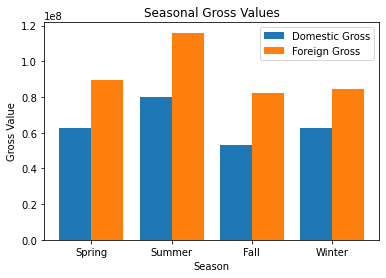

In [93]:
w=0.4
x = ['Spring', 'Summer', 'Fall', 'Winter']
domestic_gross_x = [6.286046e+07, 8.006786e+07, 5.330879e+07, 6.289587e+07]
foreign_gross = [8.961715e+07, 1.160124e+08, 8.214393e+07, 8.460717e+07]

bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]

plt.bar(bar1,domestic_gross_x,w,label='Domestic Gross')
plt.bar(bar2,foreign_gross,w,label='Foreign Gross')
plt.title('Seasonal Gross Values')
plt.xticks(bar1+w/2,x)
plt.xlabel('Season')
plt.ylabel('Gross Value')
plt.legend()
plt.show()

#### Hypothesis Testing

##### Hypothesis
    Null: There is no significant difference between the summer release dates and non summer release dates. H0:𝜇 ≥ 𝑥¯  
    Alternative: The the gross value is significantly bigger when released than not released in summer mean. 𝐻𝑎: 𝜇<𝑥¯
    Alpha= .02

**We will be performing a**  
<span style='color: red'>TODO</span>  
Finish this

In [94]:
winter = movieGrossJoinBudgets['Season'].values == 4
spring = movieGrossJoinBudgets['Season'].values == 1
fall = movieGrossJoinBudgets['Season'].values == 3

forSpring = movieGrossJoinBudgets.loc[spring]['foreign_gross']
domSpring = movieGrossJoinBudgets.loc[spring]['domestic_gross_x']
forFall = movieGrossJoinBudgets.loc[fall]['foreign_gross']
domFall = movieGrossJoinBudgets.loc[fall]['domestic_gross_x']
forWinter = movieGrossJoinBudgets.loc[winter]['foreign_gross']
domWinter = movieGrossJoinBudgets.loc[winter]['domestic_gross_x']

<span style="color: red;">TODO</span>  
Change 1 sample test to 2 sample test; divide p_val by 2 for 1-sample test; give explanation at beginning of section for hypothesis test approach

In [95]:
# T-test for foriegn market in summer
stat, pval = st.ttest_ind(forSummer, movieGrossJoinBudgets['foreign_gross'].mean(), equal_var = False)
pval/2

C:\Users\alexwhite2\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\alexwhite2\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\alexwhite2\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


nan

In [96]:
#T-test for domestic market for summer
stat, pval = st.ttest_ind(domSummer, movieGrossJoinBudgets['domestic_gross_x'].mean(), equal_var = False)
pval/2

nan

#  Decision

Since pvalue both pvalue for foreign and domestic gross are less than an alpha = .02 we reject the null.  
Stating that we are 98% sure that movies released in the Summer will result in larger gross profits.

## ANOVA Test

<span style="color: red;">TODO</span>  
Explain test
Establish H0/HA and alpha = 0.02

In [97]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('foreign_gross ~ C(Season)', data=movieGrossJoinBudgets).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Season),2.427040e+17,3.0,3.382495,0.017637
Residual,3.116469e+19,1303.0,NaN,NaN


In [98]:
model = ols('domestic_gross_x ~ C(Season)', data=movieGrossJoinBudgets).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Season),1.279204e+17,3.0,5.427947,0.001037
Residual,1.023593e+19,1303.0,NaN,NaN


We conclude that there is a statistical difference between at least one pair of seasons. 

We will test summer against each season to see if it performs significantly better than each.

<span style="color: red">TODO</span>  
Show all of below in one table

In [99]:
#summer vs spring: for
stat, pval = st.ttest_ind(forSummer,forSpring,equal_var = False)
pval/2

2.1869211270872725e-05

In [100]:
#summer vs fall: for
stat, pval =st.ttest_ind(forSummer,forFall,equal_var = False)
pval/2

2.4614528754853014e-05

In [101]:
#summer vs winter: for
stat, pval =st.ttest_ind(forSummer,forWinter,equal_var = False)
pval/2

1.256499056325375e-05

In [102]:
#summer vs spring: Dom
stat, pval =st.ttest_ind(domSummer,domSpring,equal_var = False)
pval/2

0.015404473777821429

In [103]:
#summer vs fall: dome
stat, pval =st.ttest_ind(domSummer,domFall,equal_var= False)
pval/2

0.2216923676198902

In [104]:
#summer vs winter: dom
stat, pval =st.ttest_ind(domSummer,domWinter,equal_var = False)
pval/2

0.008295581757871684

<span style="color: red;">TODO</span>  
Rephrase since using one-tailed tests

Given alpha=0.02:
* We found a significant difference between summer and all other seasons for the domestic market.
* We found a significant difference between summer with fall and winter for the foreign market.
* We did not find a significant difference between summer and spring in the foreign market.

<span style='color: red'>TODO</span>  
Alex W.:  
Add conclusion  
Make explicit business suggestions and actionable insights